In [4]:
import scipy.io
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score


for i in range(1,13):
    print("Participant", i)
    # Load the .mat file
    data1 = scipy.io.loadmat(r"C:\Users\giuli\Downloads\bci_dataset\\"+str(i)+"\\"+str(i)+"\Fatigue_state_Preprocessed.mat")

    t1=data1['samples']

    # # Access a specific variable from the .mat file

    # Loop over each column using indices
    l=0

    xList1=[]
    xSmallList1 = []
    yList1=[]


    transpose1 = t1.T
    transpose1 = pd.DataFrame(transpose1)
    t1 = pd.DataFrame(t1)


    for col_idx in range(1, t1.shape[1]-1,3):  # Iterate over columns for t1
        x = t1.iloc[:, col_idx-1:col_idx+2].to_numpy()  # Select three consecutive columns
        xList1.append(x)
        yList1.append(1)


    # Load the .mat file
    data = scipy.io.loadmat(r"C:\Users\giuli\Downloads\bci_dataset\\" + str(i) + "\\" + str(i) + r"\Normal_state_Preprocessed.mat")

    t=data['samples']

    transpose = t.T
    transpose = pd.DataFrame(transpose)
    t = pd.DataFrame(t)

    # Loop over each column using indices
    l=0

    xList=[]
    yList=[]


    for col_idx in range(1, t.shape[1]-1,3):  # Iterate over columns for t
        x = t.iloc[:, col_idx-1:col_idx+2].to_numpy()  # Select three consecutive columns
        xList.append(x)
        yList.append(0)

    if len(xList1) > len(xList):
        xList1 = xList1[:len(xList)]
        yList1 = yList1[:len(yList)]
    elif len(xList) > len(xList1):
        xList = xList[:len(xList1)]
        yList = yList[:len(yList1)]


    # Combine and shuffle datasets
    combined_xList = xList + xList1
    combined_yList = yList + yList1

    combined_data = list(zip(combined_xList, combined_yList))
    random.shuffle(combined_data)

    X, y = zip(*combined_data)

    X = np.array(X)
    y = np.array(y)
    X = X.transpose(0, 2, 1)  # Transpose to get the desired shape for LSTM input


    X_trainVal, X_test, y_trainVal, y_test = train_test_split(X, y, test_size = 0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size = 0.11111)

    def summarize_diagnostics(history):
        # plot loss
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
        plt.legend(['training', 'validation'])
        plt.show()




    def build_model(recurrent_layer_type, seq_len, num_features):

        lstm = Sequential()
        lstm.add(recurrent_layer_type(64, input_shape = (seq_len, num_features), activation="relu", return_sequences=True))
        lstm.add(recurrent_layer_type(16, activation = "relu", return_sequences=False))
        lstm.add(Dense(1, activation = 'sigmoid'))

        lstm.compile(loss = 'binary_crossentropy', optimizer = "adam", metrics = ['accuracy'])
        return lstm

    lstm = build_model(LSTM, 3, 40)
    lstm.summary()
    history = lstm.fit(X_train, y_train,
              validation_data = (X_val, y_val),
              epochs = 5,
              verbose=2,
              batch_size = 10)


    def build_simple_transformer_model(seq_len, num_features):
        inputs = Input(shape=(seq_len, num_features))

        # Positional Encoding
        position_enc = np.array([
            [pos / np.power(10000, 2 * (i // 2) / num_features) for i in range(num_features)]
            for pos in range(seq_len)])
        position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # apply sin to even indices
        position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # apply cos to odd indices
        position_enc = position_enc[np.newaxis, ...]

        x = inputs + position_enc

        # Transformer Encoder Layer
        attn_output = MultiHeadAttention(num_heads=2, key_dim=num_features)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization()(x)

        # Feed-Forward Network (FFN)
        ffn = TimeDistributed(Dense(units=num_features, activation="relu"))(x)
        ffn = TimeDistributed(Dense(units=num_features))(ffn)
        ffn = Dropout(0.1)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization()(x)

        # Global average pooling and Dense layer for classification
        x = GlobalAveragePooling1D()(x)
        x = Dense(16, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

        return model

    # Assuming you have X_train, X_val, y_train, and y_val defined
    seq_len = 3
    num_features = 40

    # Build the simplified Transformer model
    transformer_model = build_simple_transformer_model(seq_len, num_features)
    transformer_model.summary()

    # Train the model
    history1 = transformer_model.fit(X_train, y_train,
                                    validation_data=(X_val, y_val),
                                    epochs=5,
                                    batch_size=10,
                                    verbose=2,
                                    callbacks=[EarlyStopping(patience=3)])

    y_pred_lstm = lstm.predict(X_test)
    y_pred_lstm = (y_pred_lstm > 0.5)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)
    print("LSTM Model Confusion Matrix:")
    print(cm_lstm)
    print("LSTM Model Accuracy:", accuracy_score(y_test, y_pred_lstm))

    # Evaluate Transformer model
    y_pred_transformer = transformer_model.predict(X_test)
    y_pred_transformer = (y_pred_transformer > 0.5)
    cm_transformer = confusion_matrix(y_test, y_pred_transformer)
    print("Transformer Model Confusion Matrix:")
    print(cm_transformer)
    print("Transformer Model Accuracy:", accuracy_score(y_test, y_pred_transformer))


Participant 1
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 64)             26880     
                                                                 
 lstm_5 (LSTM)               (None, 16)                5184      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
5350/5350 - 14s - loss: 0.1188 - accuracy: 0.9518 - val_loss: 0.0285 - val_accuracy: 0.9898 - 14s/epoch - 3ms/step
Epoch 2/5
5350/5350 - 12s - loss: 0.0265 - accuracy: 0.9916 - val_loss: 0.0126 - val_accuracy: 0.9960 - 12s/epoch - 2ms/step
Epoch 3/5
5350/5

C:\Users\giuli\anaconda3.2\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\giuli\anaconda3.2\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Participant 1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 64)             26880     
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
5350/5350 - 37s - loss: 0.1235 - accuracy: 0.9495 - val_loss: 0.0292 - val_accuracy: 0.9895 - 37s/epoch - 7ms/step
Epoch 2/5
5350/5350 - 33s - loss: 0.0263 - accuracy: 0.9916 - val_loss: 0.0192 - val_accuracy: 0.9936 - 33s/epoch - 6ms/step
Epoch 3/5
5350/535

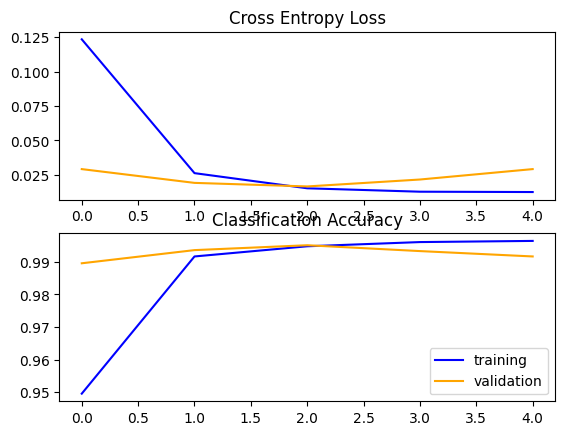

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 3, 40)       0           ['input_1[0][0]']                
 da)                                                                                              
                                                                                                  
 multi_head_attention (MultiHea  (None, 3, 40)       13080       ['tf.__operators__.add[0][0]',   
 dAttention)                                                      'tf.__operators__.add[0][0]']   
                                                                                              

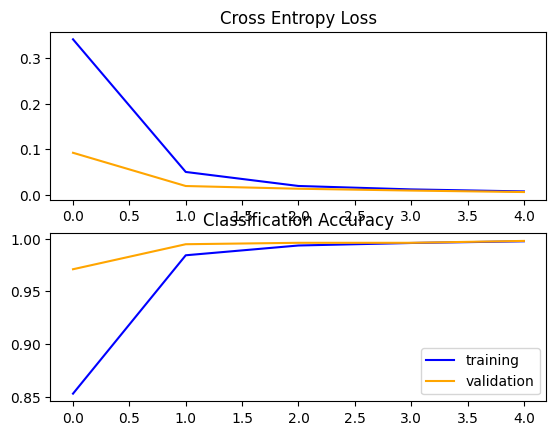

209/209 [==============================] - 1s 4ms/step
LSTM Model Confusion Matrix:
[[3270   40]
 [   3 3374]]
LSTM Model Accuracy: 0.9935696126813219
209/209 [==============================] - 1s 5ms/step
Transformer Model Confusion Matrix:
[[3306    4]
 [  11 3366]]
Transformer Model Accuracy: 0.9977568416330193
Participant 2
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 3, 64)             26880     
                                                                 
 lstm_3 (LSTM)               (None, 16)                5184      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
________________

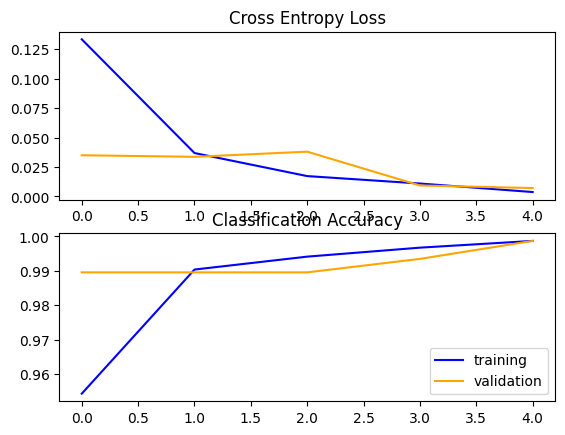

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_1 (TFOpLa  (None, 3, 40)       0           ['input_2[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_1[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_1[0][0]'] 
                                                                                            

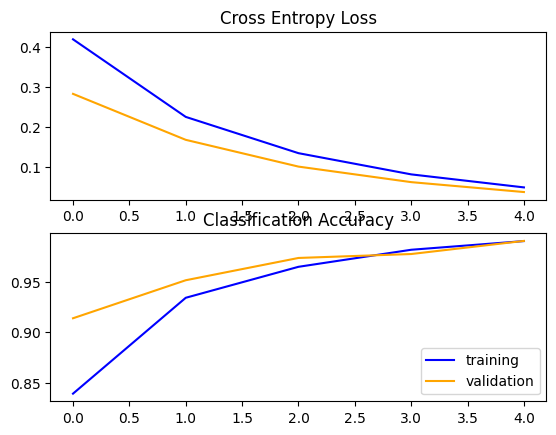

24/24 [==============================] - 1s 4ms/step
LSTM Model Confusion Matrix:
[[367   1]
 [  2 397]]
LSTM Model Accuracy: 0.9960886571056062
24/24 [==============================] - 0s 5ms/step
Transformer Model Confusion Matrix:
[[367   1]
 [  6 393]]
Transformer Model Accuracy: 0.9908735332464146
Participant 3
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 3, 64)             26880     
                                                                 
 lstm_5 (LSTM)               (None, 16)                5184      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
____________________________

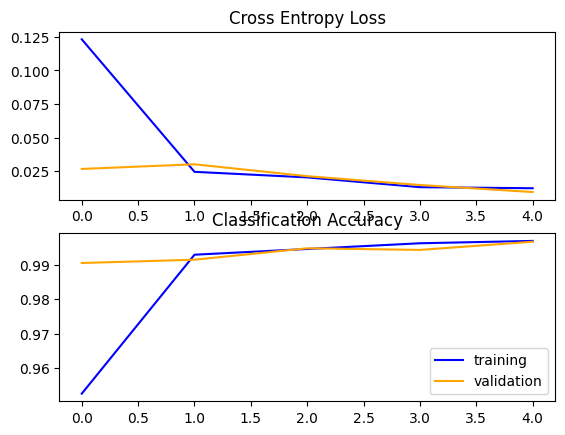

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 3, 40)       0           ['input_3[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_2 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_2[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_2[0][0]'] 
                                                                                            

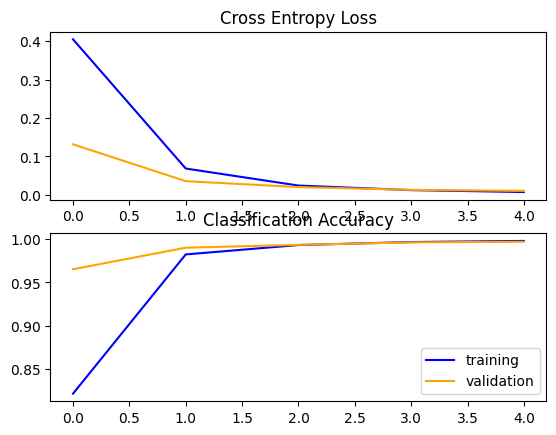

132/132 [==============================] - 1s 5ms/step
LSTM Model Confusion Matrix:
[[2096    6]
 [   7 2104]]
LSTM Model Accuracy: 0.9969143128412058
132/132 [==============================] - 1s 6ms/step
Transformer Model Confusion Matrix:
[[2092   10]
 [   5 2106]]
Transformer Model Accuracy: 0.9964395917398529
Participant 4
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 3, 64)             26880     
                                                                 
 lstm_7 (LSTM)               (None, 16)                5184      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
________________

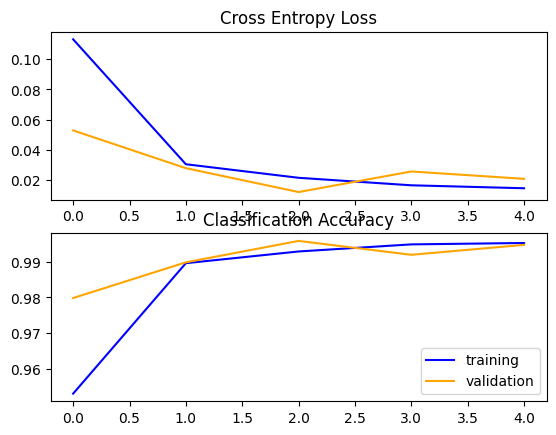

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_3 (TFOpLa  (None, 3, 40)       0           ['input_4[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_3 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_3[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_3[0][0]'] 
                                                                                            

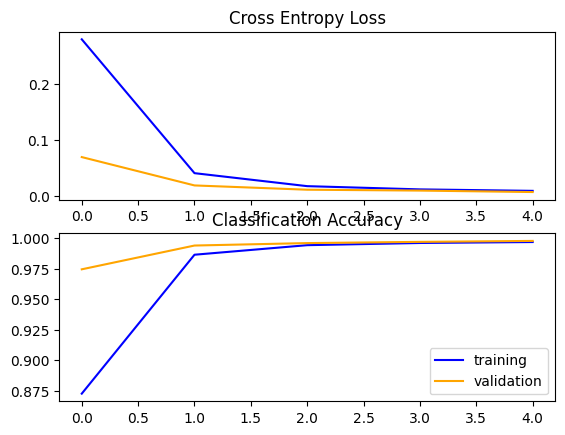

281/281 [==============================] - 1s 1ms/step
LSTM Model Confusion Matrix:
[[4484   13]
 [  29 4457]]
LSTM Model Accuracy: 0.9953245018368029
281/281 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[4488    9]
 [  15 4471]]
Transformer Model Accuracy: 0.9973282867638873
Participant 5
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 64)             26880     
                                                                 
 lstm_9 (LSTM)               (None, 16)                5184      
                                                                 
 dense_20 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
________________

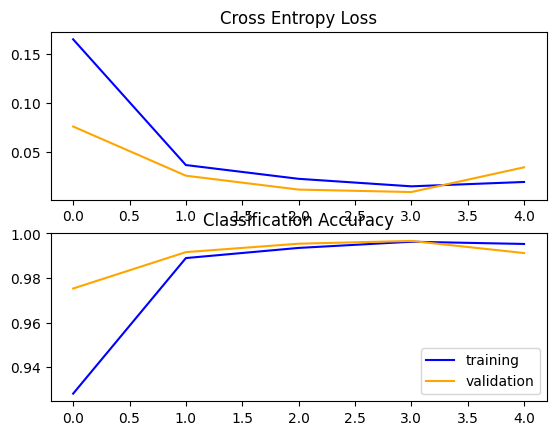

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_4 (TFOpLa  (None, 3, 40)       0           ['input_5[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_4 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_4[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_4[0][0]'] 
                                                                                            

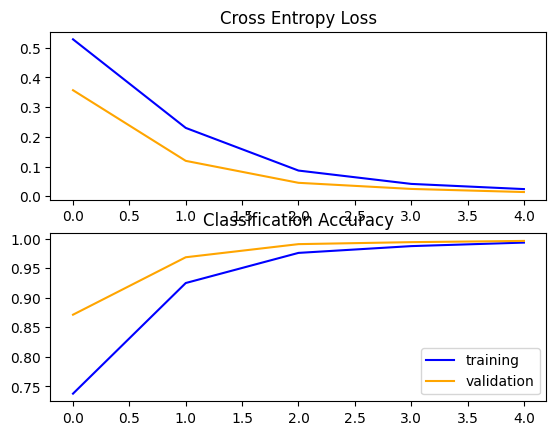

75/75 [==============================] - 1s 1ms/step
LSTM Model Confusion Matrix:
[[1176    5]
 [   3 1203]]
LSTM Model Accuracy: 0.9966485127775451
75/75 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[1170   11]
 [   3 1203]]
Transformer Model Accuracy: 0.9941348973607038
Participant 6
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_11 (LSTM)              (None, 16)                5184      
                                                                 
 dense_25 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

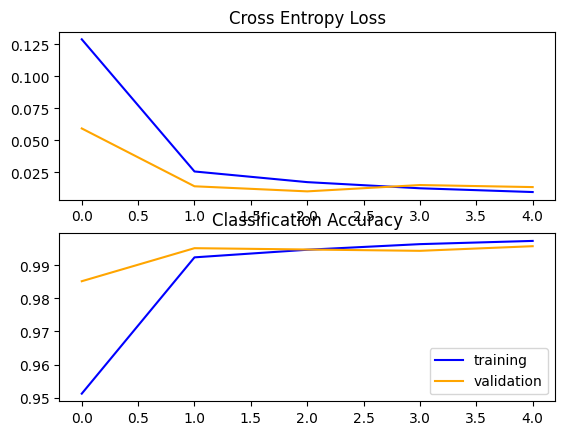

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_5 (TFOpLa  (None, 3, 40)       0           ['input_6[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_5 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_5[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_5[0][0]'] 
                                                                                            

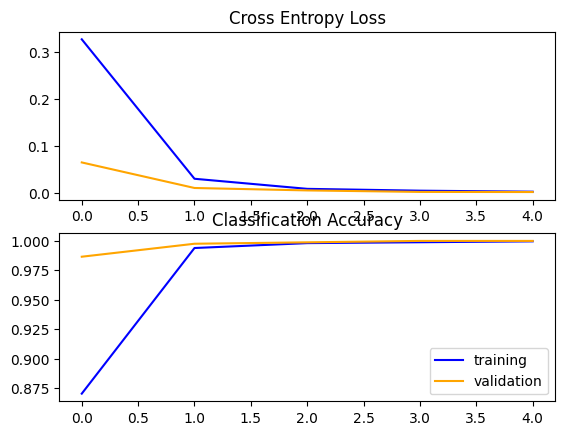

157/157 [==============================] - 0s 1ms/step
LSTM Model Confusion Matrix:
[[2489   21]
 [   3 2490]]
LSTM Model Accuracy: 0.9952028782730362
157/157 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[2505    5]
 [   1 2492]]
Transformer Model Accuracy: 0.998800719568259
Participant 7
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_13 (LSTM)              (None, 16)                5184      
                                                                 
 dense_30 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________

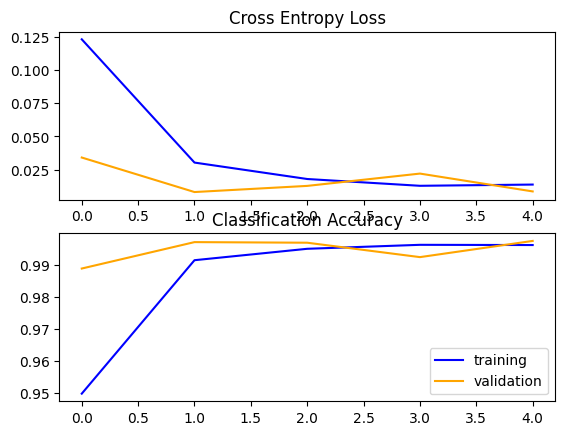

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_6 (TFOpLa  (None, 3, 40)       0           ['input_7[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_6 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_6[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_6[0][0]'] 
                                                                                            

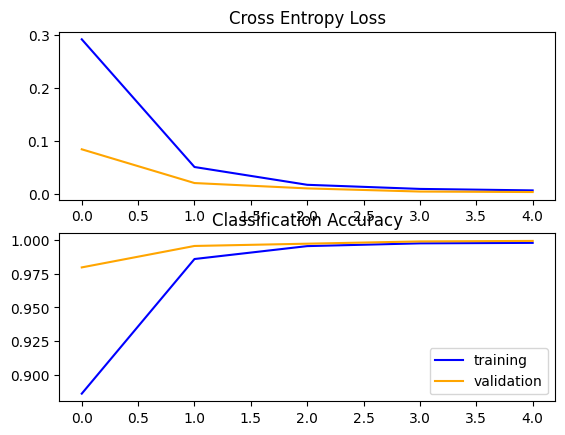

167/167 [==============================] - 0s 1ms/step
LSTM Model Confusion Matrix:
[[2639    1]
 [   8 2682]]
LSTM Model Accuracy: 0.9983114446529081
167/167 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[2636    4]
 [  11 2679]]
Transformer Model Accuracy: 0.9971857410881801
Participant 8
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_15 (LSTM)              (None, 16)                5184      
                                                                 
 dense_35 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
________________

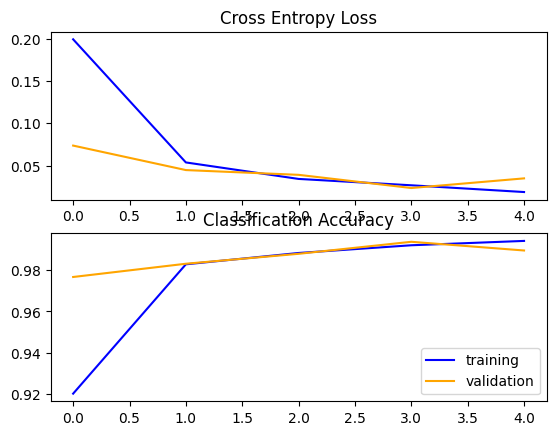

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_7 (TFOpLa  (None, 3, 40)       0           ['input_8[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_7 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_7[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_7[0][0]'] 
                                                                                            

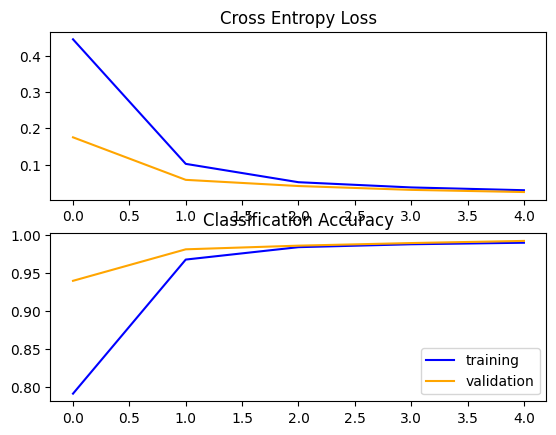

156/156 [==============================] - 1s 2ms/step
LSTM Model Confusion Matrix:
[[2528   14]
 [  49 2383]]
LSTM Model Accuracy: 0.9873341375150784
156/156 [==============================] - 1s 2ms/step
Transformer Model Confusion Matrix:
[[2511   31]
 [   4 2428]]
Transformer Model Accuracy: 0.9929634097305992
Participant 9
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_17 (LSTM)              (None, 16)                5184      
                                                                 
 dense_40 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
________________

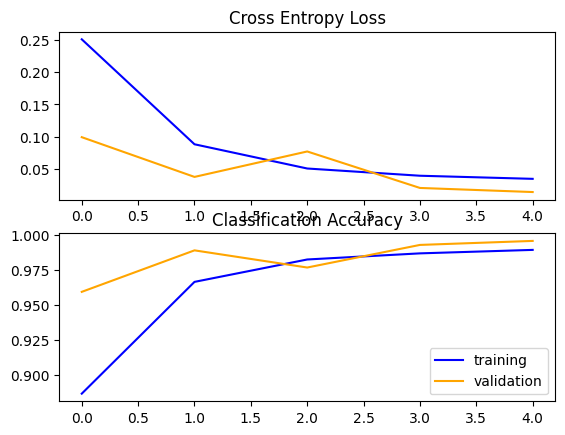

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_8 (TFOpLa  (None, 3, 40)       0           ['input_9[0][0]']                
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_8 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_8[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_8[0][0]'] 
                                                                                            

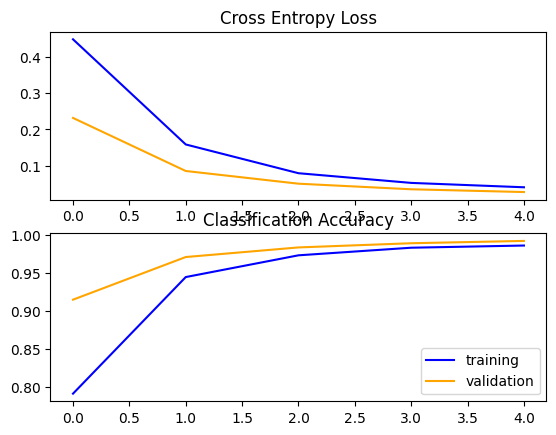

153/153 [==============================] - 0s 2ms/step
LSTM Model Confusion Matrix:
[[2448    9]
 [   7 2428]]
LSTM Model Accuracy: 0.9967293540474244
153/153 [==============================] - 0s 2ms/step
Transformer Model Confusion Matrix:
[[2436   21]
 [  28 2407]]
Transformer Model Accuracy: 0.9899836467702371
Participant 10
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_19 (LSTM)              (None, 16)                5184      
                                                                 
 dense_45 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

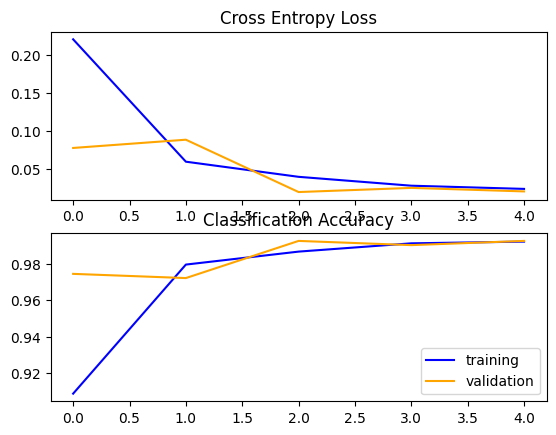

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_9 (TFOpLa  (None, 3, 40)       0           ['input_10[0][0]']               
 mbda)                                                                                            
                                                                                                  
 multi_head_attention_9 (MultiH  (None, 3, 40)       13080       ['tf.__operators__.add_9[0][0]', 
 eadAttention)                                                    'tf.__operators__.add_9[0][0]'] 
                                                                                            

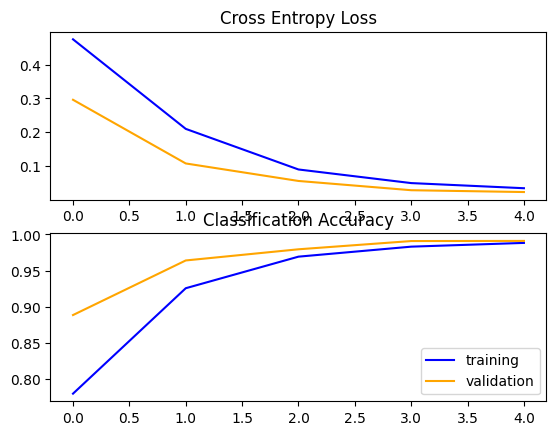

162/162 [==============================] - 0s 2ms/step
LSTM Model Confusion Matrix:
[[2568   24]
 [  15 2574]]
LSTM Model Accuracy: 0.9924724956572091
162/162 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[2564   28]
 [  18 2571]]
Transformer Model Accuracy: 0.991121405134144
Participant 11
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_21 (LSTM)              (None, 16)                5184      
                                                                 
 dense_50 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
_______________

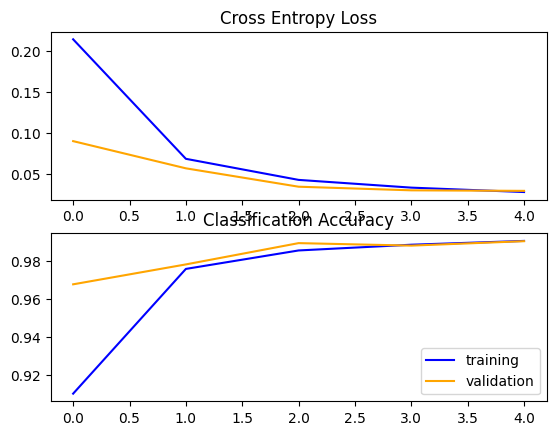

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_10 (TFOpL  (None, 3, 40)       0           ['input_11[0][0]']               
 ambda)                                                                                           
                                                                                                  
 multi_head_attention_10 (Multi  (None, 3, 40)       13080       ['tf.__operators__.add_10[0][0]',
 HeadAttention)                                                   'tf.__operators__.add_10[0][0]']
                                                                                           

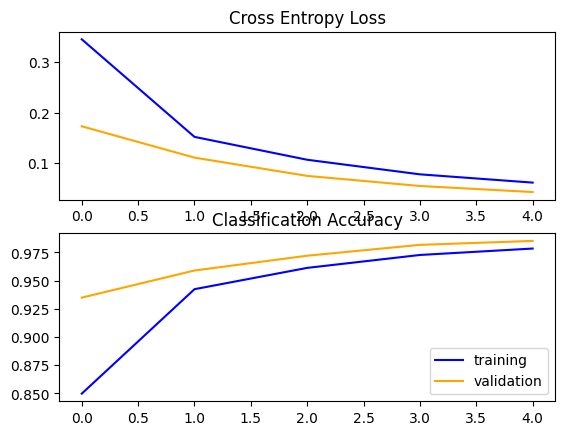

215/215 [==============================] - 0s 1ms/step
LSTM Model Confusion Matrix:
[[3337   32]
 [  41 3457]]
LSTM Model Accuracy: 0.9893694480850445
215/215 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[3321   48]
 [  51 3447]]
Transformer Model Accuracy: 0.9855832241153342
Participant 12
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 3, 64)             26880     
                                                                 
 lstm_23 (LSTM)              (None, 16)                5184      
                                                                 
 dense_55 (Dense)            (None, 1)                 17        
                                                                 
Total params: 32081 (125.32 KB)
Trainable params: 32081 (125.32 KB)
Non-trainable params: 0 (0.00 Byte)
______________

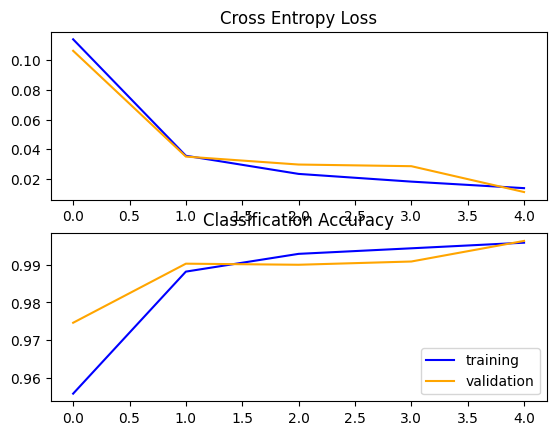

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 3, 40)]      0           []                               
                                                                                                  
 tf.__operators__.add_11 (TFOpL  (None, 3, 40)       0           ['input_12[0][0]']               
 ambda)                                                                                           
                                                                                                  
 multi_head_attention_11 (Multi  (None, 3, 40)       13080       ['tf.__operators__.add_11[0][0]',
 HeadAttention)                                                   'tf.__operators__.add_11[0][0]']
                                                                                           

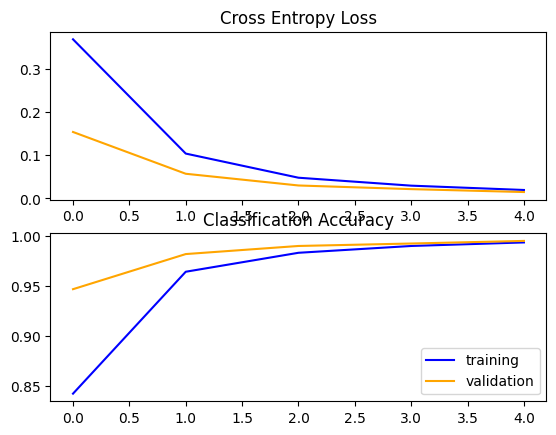

217/217 [==============================] - 1s 1ms/step
LSTM Model Confusion Matrix:
[[3483   10]
 [   8 3426]]
LSTM Model Accuracy: 0.9974014724989173
217/217 [==============================] - 0s 1ms/step
Transformer Model Confusion Matrix:
[[3483   10]
 [  29 3405]]
Transformer Model Accuracy: 0.9943698570809875


In [1]:
import scipy.io
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, GRU, Input, LayerNormalization, Add, TimeDistributed, GlobalAveragePooling1D, MultiHeadAttention
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt


for i in range(1,13):
    print("Participant", i)
    # Load the .mat file for Fatigue state
    data1 = scipy.io.loadmat(r"C:\Users\giuli\Downloads\bci_dataset\\"+str(i)+"\\"+str(i)+"\Fatigue_state_Preprocessed.mat")
    t1 = data1['samples']
    t1 = pd.DataFrame(t1)

    xList1 = []
    yList1 = []

    for col_idx in range(1, t1.shape[1]-1,3):
        x = t1.iloc[:, col_idx-1:col_idx+2].to_numpy()
        xList1.append(x)
        yList1.append(1)

    # Load the .mat file for Normal state
    data = scipy.io.loadmat(r"C:\Users\giuli\Downloads\bci_dataset\\" + str(i) + "\\" + str(i) + r"\Normal_state_Preprocessed.mat")
    t = data['samples']
    t = pd.DataFrame(t)

    xList = []
    yList = []

    for col_idx in range(1, t.shape[1]-1,3):
        x = t.iloc[:, col_idx-1:col_idx+2].to_numpy()
        xList.append(x)
        yList.append(0)

    # Ensure equal length for both xList1 and xList
    min_length = min(len(xList1), len(xList))
    xList1 = xList1[:min_length]
    yList1 = yList1[:min_length]
    xList = xList[:min_length]
    yList = yList[:min_length]

    # Combine and shuffle datasets
    combined_xList = xList + xList1
    combined_yList = yList + yList1

    combined_data = list(zip(combined_xList, combined_yList))
    random.shuffle(combined_data)

    X, y = zip(*combined_data)

    X = np.array(X)
    y = np.array(y)
    X = X.transpose(0, 2, 1)  # Transpose to get the desired shape for LSTM input

    # Generate noise with mean 0 and standard deviation 0.5
    noise = np.random.normal(loc=0, scale=0.5, size=X.shape)

    # Add noise to X
    X_noisy = X + noise

    # Split into train, validation, and test sets
    X_trainVal, X_test, y_trainVal, y_test = train_test_split(X_noisy, y, test_size=0.1)
    X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, test_size=0.11111)

    # Function to build LSTM model
    def build_model(recurrent_layer_type, seq_len, num_features):
        lstm = Sequential()
        lstm.add(recurrent_layer_type(64, input_shape=(seq_len, num_features), activation="relu", return_sequences=True))
        lstm.add(recurrent_layer_type(16, activation="relu", return_sequences=False))
        lstm.add(Dense(1, activation='sigmoid'))
        lstm.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])
        return lstm

    # Build LSTM model
    lstm = build_model(LSTM, 3, 40)
    lstm.summary()

    # Train LSTM model
    history = lstm.fit(X_train, y_train,
                       validation_data=(X_val, y_val),
                       epochs=5,
                       verbose=2,
                       batch_size=10)

    # Function to summarize model diagnostics
    def summarize_diagnostics(history):
        plt.subplot(211)
        plt.title('Cross Entropy Loss')
        plt.plot(history.history['loss'], color='blue', label='train')
        plt.plot(history.history['val_loss'], color='orange', label='test')
        plt.subplot(212)
        plt.title('Classification Accuracy')
        plt.plot(history.history['accuracy'], color='blue', label='train')
        plt.plot(history.history['val_accuracy'], color='orange', label='test')
        plt.legend(['training', 'validation'])
        plt.show()

    # Summarize LSTM model diagnostics
    summarize_diagnostics(history)

    # Function to build Transformer model
    def build_simple_transformer_model(seq_len, num_features):
        inputs = Input(shape=(seq_len, num_features))
        position_enc = np.array([
            [pos / np.power(10000, 2 * (i // 2) / num_features) for i in range(num_features)]
            for pos in range(seq_len)])
        position_enc[:, 0::2] = np.sin(position_enc[:, 0::2])  # apply sin to even indices
        position_enc[:, 1::2] = np.cos(position_enc[:, 1::2])  # apply cos to odd indices
        position_enc = position_enc[np.newaxis, ...]
        x = inputs + position_enc
        attn_output = MultiHeadAttention(num_heads=2, key_dim=num_features)(x, x)
        attn_output = Dropout(0.1)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization()(x)
        ffn = TimeDistributed(Dense(units=num_features, activation="relu"))(x)
        ffn = TimeDistributed(Dense(units=num_features))(ffn)
        ffn = Dropout(0.1)(ffn)
        x = Add()([x, ffn])
        x = LayerNormalization()(x)
        x = GlobalAveragePooling1D()(x)
        x = Dense(16, activation='relu')(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
        return model

    # Build Transformer model
    seq_len = 3
    num_features = 40
    transformer_model = build_simple_transformer_model(seq_len, num_features)
    transformer_model.summary()

    # Train Transformer model
    history1 = transformer_model.fit(X_train, y_train,
                                    validation_data=(X_val, y_val),
                                    epochs=5,
                                    batch_size=10,
                                    verbose=2,
                                    callbacks=[EarlyStopping(patience=3)])

    # Summarize Transformer model diagnostics
    summarize_diagnostics(history1)

    # Evaluate LSTM model
    y_pred_lstm = lstm.predict(X_test)
    y_pred_lstm = (y_pred_lstm > 0.5)
    cm_lstm = confusion_matrix(y_test, y_pred_lstm)
    print("LSTM Model Confusion Matrix:")
    print(cm_lstm)
    print("LSTM Model Accuracy:", accuracy_score(y_test, y_pred_lstm))

    # Evaluate Transformer model
    y_pred_transformer = transformer_model.predict(X_test)
    y_pred_transformer = (y_pred_transformer > 0.5)
    cm_transformer = confusion_matrix(y_test, y_pred_transformer)
    print("Transformer Model Confusion Matrix:")
    print(cm_transformer)
    print("Transformer Model Accuracy:", accuracy_score(y_test, y_pred_transformer))
    